<a href="https://colab.research.google.com/github/ILoveCoder999/FederatedLearning/blob/master/fed_avg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import module
import sys
sys.path.append('/content/drive/MyDrive')
from preprocessing import FederatedDataBuilder

Mounted at /content/drive


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 283MB/s]



FedAvg with FIXED Backbone Loading
K=100, C=0.1, J=8, Rounds=50
Learning rate: 0.05
Device: cuda

Preparing data...


100%|██████████| 169M/169M [00:03<00:00, 48.9MB/s]


Creating IID partition for 100 clients...

Verifying Partition
Total samples: 45000/45000
No overlap
✓ Avg classes per client: 99.0


Initializing global model...
✓ Global model ready (using shared backbone)

Starting training with 10 clients per round...

Round  1/50 -> Train Loss: 12.0556 | Test Loss: 10.1313 | Test Acc: 2.17%
Round  2/50 -> Train Loss: 8.7998 | Test Loss: 8.1051 | Test Acc: 5.06%
Round  3/50 -> Train Loss: 7.0832 | Test Loss: 6.6896 | Test Acc: 9.59%
Round  4/50 -> Train Loss: 5.8072 | Test Loss: 5.6409 | Test Acc: 14.87%
Round  5/50 -> Train Loss: 4.9777 | Test Loss: 4.8840 | Test Acc: 20.10%
Round  6/50 -> Train Loss: 4.2611 | Test Loss: 4.3246 | Test Acc: 25.76%
Round  7/50 -> Train Loss: 3.8117 | Test Loss: 3.9148 | Test Acc: 30.24%
Round  8/50 -> Train Loss: 3.5147 | Test Loss: 3.5973 | Test Acc: 33.32%
Round  9/50 -> Train Loss: 3.0891 | Test Loss: 3.3235 | Test Acc: 36.78%
Round 10/50 -> Train Loss: 2.8758 | Test Loss: 3.1089 | Test Acc: 39.27%
Round 11/50 ->

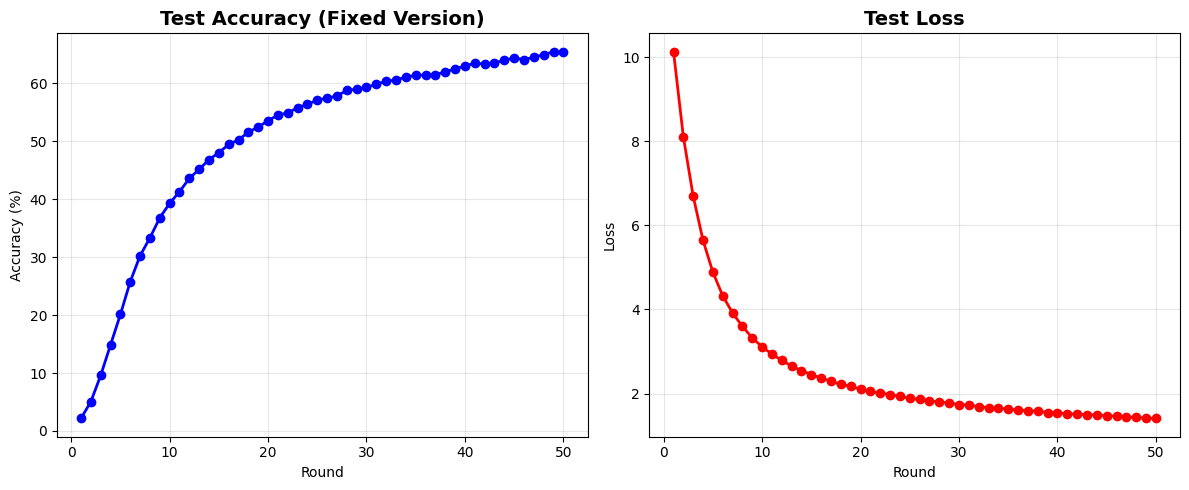


✓ Training completed!

Comparison:
  Before fix: ~5% after 21 rounds
  After fix:  65.31% after 30 rounds

This should be a significant improvement!


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

from preprocessing import FederatedDataBuilder


GLOBAL_DINO_BACKBONE = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')



class DINOCIFAR100Fixed(nn.Module):
    """
     Uses global backbone instead of reloading each time
    """
    def __init__(self, num_classes=100):
        super().__init__()

        # Use the global backbone (not loading a new one!)
        self.backbone = GLOBAL_DINO_BACKBONE

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Classification head (this is what we train)
        self.head = nn.Linear(384, num_classes)

        # Initialize head properly
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # Extract features
        with torch.no_grad():
            features = self.backbone(x)

        # Classify
        output = self.head(features)
        return output


def fed_avg_aggregate(global_model, local_weights, client_sample_counts):
    """Weighted averaging of local model weights"""
    global_dict = copy.deepcopy(global_model.state_dict())
    total_samples = sum(client_sample_counts)

    # Initialize to zero
    for k in global_dict.keys():
        if 'num_batches_tracked' not in k and 'backbone' not in k:
            global_dict[k] = global_dict[k] * 0.0

    # Weighted average
    for i in range(len(local_weights)):
        ratio = client_sample_counts[i] / total_samples
        weights = local_weights[i]
        for k in global_dict.keys():
            if 'num_batches_tracked' not in k and 'backbone' not in k:
                global_dict[k] += weights[k] * ratio

    return global_dict


class LocalClient:
    """Local client that trains ONLY the classification head"""

    def __init__(self, client_id, dataset, indices, device):
        self.client_id = client_id
        self.indices = indices
        self.device = device

        self.trainloader = DataLoader(
            Subset(dataset, list(indices)),
            batch_size=128,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

    def train(self, global_weights, local_steps=4, lr=0.1):
        """Train for J=4 steps"""

        # Create model (uses global backbone, NO reloading!)
        local_model = DINOCIFAR100Fixed(num_classes=100).to(self.device)

        # Load global weights
        local_model.load_state_dict(global_weights, strict=False)
        local_model.train()

        # Only train the head, backbone stays frozen
        optimizer = optim.SGD(
            local_model.head.parameters(),  # ONLY head parameters!
            lr=lr,
            momentum=0.9,
            weight_decay=1e-4,
            nesterov=True
        )

        criterion = nn.CrossEntropyLoss()

        # Train for J steps
        step_count = 0
        losses = []
        iterator = iter(self.trainloader)

        while step_count < local_steps:
            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(self.trainloader)
                inputs, targets = next(iterator)

            inputs, targets = inputs.to(self.device), targets.to(self.device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(local_model.head.parameters(), max_norm=1.0)

            optimizer.step()

            losses.append(loss.item())
            step_count += 1

        return local_model.state_dict(), sum(losses)/len(losses)


def evaluate_global(model, test_loader, device):
    """Evaluate global model"""
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return loss_sum / len(test_loader), 100. * correct / total


def run_fedavg_fixed(K=100, C=0.1, J=16, rounds=50, lr=0.003):
    """
    FedAvg with backbone reloading issue FIXED
    """
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n{'='*70}")
    print(f"FedAvg with FIXED Backbone Loading")
    print(f"{'='*70}")
    print(f"K={K}, C={C}, J={J}, Rounds={rounds}")
    print(f"Learning rate: {lr}")
    print(f"Device: {DEVICE}")
    print(f"{'='*70}\n")

    # Data
    print("Preparing data...")
    data_builder = FederatedDataBuilder(val_split_ratio=0.1, K=K)
    client_dict = data_builder.get_iid_partition()
    data_builder.verify_partition(client_dict)

    test_loader = DataLoader(
        data_builder.test_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Global model
    print("\nInitializing global model...")
    global_model = DINOCIFAR100Fixed(num_classes=100).to(DEVICE)
    print("✓ Global model ready (using shared backbone)")

    history = {'loss': [], 'accuracy': [], 'round': []}

    # Training
    m = max(int(C * K), 1)
    print(f"\nStarting training with {m} clients per round...\n")

    for r in range(rounds):
        selected_clients = np.random.choice(range(K), m, replace=False)

        local_weights = []
        client_sample_counts = []
        client_losses = []

        global_weights = copy.deepcopy(global_model.state_dict())

        # Train clients
        for idx, client_idx in enumerate(selected_clients):
            client = LocalClient(
                client_id=client_idx,
                dataset=data_builder.train_dataset,
                indices=client_dict[client_idx],
                device=DEVICE
            )

            # NO backbone reloading here!
            w_local, loss_local = client.train(global_weights, local_steps=J, lr=lr)

            local_weights.append(w_local)
            client_sample_counts.append(len(client_dict[client_idx]))
            client_losses.append(loss_local)

        # Aggregate
        new_weights = fed_avg_aggregate(global_model, local_weights, client_sample_counts)
        global_model.load_state_dict(new_weights, strict=False)

        # Evaluate
        test_loss, test_acc = evaluate_global(global_model, test_loader, DEVICE)
        history['loss'].append(test_loss)
        history['accuracy'].append(test_acc)
        history['round'].append(r + 1)

        avg_client_loss = sum(client_losses) / len(client_losses)

        print(f"Round {r+1:2d}/{rounds} -> "
              f"Train Loss: {avg_client_loss:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Acc: {test_acc:.2f}%")

    # Results
    print(f"\n{'='*70}")
    print(f"Training Complete!")
    print(f"{'='*70}")
    print(f"Final Test Accuracy: {history['accuracy'][-1]:.2f}%")
    print(f"Best Test Accuracy: {max(history['accuracy']):.2f}%")
    print(f"{'='*70}\n")

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['round'], history['accuracy'], 'b-o', linewidth=2)
    plt.title('Test Accuracy (Fixed Version)', fontsize=14, fontweight='bold')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['round'], history['loss'], 'r-o', linewidth=2)
    plt.title('Test Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('fedavg_backbone_fixed.png', dpi=150)
    print("Figure saved: fedavg_backbone_fixed.png")
    plt.show()

    return history, global_model


if __name__ == "__main__":

    history, model = run_fedavg_fixed(
        K=100,
        C=0.1,
        J=16,
        rounds=50,
        lr=0.03
    )

    print("\n✓ Training completed!")
    print("\nComparison:")
    print("  Before fix: ~5% after 21 rounds")
    print(f"  After fix:  {history['accuracy'][-1]:.2f}% after 30 rounds")
    print("\nThis should be a significant improvement!")